# Potential Organ Donor Cohort Identifier

In [1]:
import sys 
import os
import polars as pl 
import matplotlib.pyplot as plt
project_root = os.path.dirname(os.getcwd())
sys.path.insert(0, project_root)
from utils.config import config
from utils.io import read_data
from utils.strobe_diagram import create_nested_funnel_diagram
from clifpy.utils.stitching_encounters import stitch_encounters

Loaded configuration from config.json


In [2]:
site_name = config['site_name']
tables_path = config['tables_path']
file_type = config['file_type']
print(f"Site Name: {site_name}")
print(f"Tables Path: {tables_path}")
print(f"File Type: {file_type}")

Site Name: UCMC
Tables Path: /Users/dema/WD/CRI_2018_24/BOX_2.1.0/2.1.0
File Type: parquet


In [3]:
# read required tables
adt_filepath = f"{tables_path}/clif_adt.{file_type}"
hospitalization_filepath = f"{tables_path}/clif_hospitalization.{file_type}"
patient_filepath = f"{tables_path}/clif_patient.{file_type}"
resp_filepath = f"{tables_path}/clif_respiratory_support.{file_type}"
labs_filepath = f"{tables_path}/clif_labs.{file_type}"
micro_culture_filepath = f"{tables_path}/clif_microbiology_culture.{file_type}"
crrt_filepath = f"{tables_path}/clif_crrt_therapy.{file_type}"
hospial_dx_filepath = f"{tables_path}/clif_hospital_diagnosis.{file_type}"


adt_df = read_data(adt_filepath, file_type)
hospitalization_df = read_data(hospitalization_filepath, file_type)
patient_df = read_data(patient_filepath, file_type)
resp_df = read_data(resp_filepath, file_type)
labs_df = read_data(labs_filepath, file_type)
micro_culture = read_data(micro_culture_filepath, file_type)
crrt_therapy = read_data(crrt_filepath, file_type)
hospital_dx = read_data(hospial_dx_filepath, file_type)

total_patients = hospitalization_df["patient_id"].n_unique()

File name: clif_adt.parquet
Time taken to load the dataset: 0.02 seconds
Size of the loaded dataset: 25.00 MB

File name: clif_hospitalization.parquet
Time taken to load the dataset: 0.01 seconds
Size of the loaded dataset: 35.41 MB

File name: clif_patient.parquet
Time taken to load the dataset: 0.00 seconds
Size of the loaded dataset: 12.01 MB

File name: clif_respiratory_support.parquet
Time taken to load the dataset: 0.07 seconds
Size of the loaded dataset: 1538.84 MB

File name: clif_labs.parquet
Time taken to load the dataset: 0.24 seconds
Size of the loaded dataset: 3526.69 MB

File name: clif_microbiology_culture.parquet
Time taken to load the dataset: 0.01 seconds
Size of the loaded dataset: 83.66 MB

File name: clif_crrt_therapy.parquet
Time taken to load the dataset: 0.01 seconds
Size of the loaded dataset: 17.89 MB

File name: clif_hospital_diagnosis.parquet
Time taken to load the dataset: 0.01 seconds
Size of the loaded dataset: 48.41 MB



In [4]:
hosp_stitched, adt_stitched, encounter_mapping = stitch_encounters(
      hospitalization=hospitalization_df.to_pandas(),
      adt=adt_df.to_pandas(),
      time_interval=12
  )

hosp_stitched = pl.from_pandas(hosp_stitched)
adt_stitched = pl.from_pandas(adt_stitched)
encounter_mapping = pl.from_pandas(encounter_mapping)

In [5]:
# Step 1: Get the admission dates for the expired
# filter to patients that expired or discharged to hospice 
expired_encounters_df = hosp_stitched.filter(
    pl.col('discharge_category').str.to_lowercase() == 'expired'
)
expired_hospitalizations = (
    expired_encounters_df
    .select([
        'patient_id',
        'hospitalization_id',
        'encounter_block',
        'admission_dttm',
        'discharge_dttm'  # discharge datetime for the death hospitalization
    ])
    .unique()
)
expired_patients_n = expired_hospitalizations["patient_id"].n_unique()

In [6]:
# Step 2- On invasive mechanical ventilation at or within 48h of death.

# Expired patients ever on IMV
imv_resp_encounters = resp_df.filter(pl.col("device_category")=="IMV") 
imv_expired = expired_hospitalizations.join(imv_resp_encounters.select(["hospitalization_id", "recorded_dttm"]), on = "hospitalization_id", how = "inner")

resp_expired_latest_recorded_imv = (
    imv_expired
    .sort("recorded_dttm", descending=True)
    .group_by("patient_id")
    .agg(pl.all().first())
)

resp_expired_imv_hrs = resp_expired_latest_recorded_imv.with_columns(
    (
        (pl.col("discharge_dttm") - pl.col("recorded_dttm")).dt.total_seconds() / 3600
    ).alias("hr_2death_last_imv")
)

# Filter to patients who were on IMV at death or before 48hrs of death 
resp_expired_cohort = resp_expired_imv_hrs.filter(pl.col('hr_2death_last_imv')<=48)

imv_expired_patients = imv_expired["patient_id"].n_unique()
imv_after_expire = resp_expired_imv_hrs.filter(pl.col('hr_2death_last_imv') <= 0)["patient_id"].n_unique()
imv_48hr_expire = resp_expired_cohort["patient_id"].n_unique()


In [7]:
# Step - 4 CONTRAINDICATIONS

# Step 4A - No positive blood cultures within 48hrs

# Step 4B - History of Cancer or Sepsis

hospital_dx_cohort = hospital_dx.filter(
    pl.col("hospitalization_id").is_in(resp_expired_cohort["hospitalization_id"].implode())
)

# Load exclusion ICD codes from CSV using polars
icd_exclu_df = pl.read_csv("../utils/icd_dx_exclu.csv")

# Clean exclusion ICD codes: lowercase, remove non-alphanumeric, and add cleaned/lookup column
icd_exclu_df = icd_exclu_df.with_columns(
    pl.col("ICD-10-CM")
    .cast(pl.Utf8)
    .str.to_lowercase()
    .str.replace_all(r"[^a-z0-9]", "")
    .alias("icd_clean")
)
icd_exclu_codes = icd_exclu_df["icd_clean"].unique().to_list()

# Clean diagnosis_code in hospital_dx_cohort
hospital_dx_cohort = hospital_dx_cohort.with_columns(
    pl.col("diagnosis_code")
    .str.to_lowercase()
    .str.replace_all(r"[^a-z0-9]", "")
    .alias("diagnosis_code_clean")
)

# Merge exclusion ICD "type" (dx_broad) to patient diagnosis matches
# Filter dx cohort to matches, then bring in dx_broad by joining to cleaned ICD lookup
hospital_dx_exclu = (
    hospital_dx_cohort
    .filter(pl.col("diagnosis_code_clean").is_in(icd_exclu_codes))
    .join(
        icd_exclu_df.select(["icd_clean", "dx_broad"]),
        left_on="diagnosis_code_clean",
        right_on="icd_clean",
        how="left"
    )
)

# Remove hospitalizations who have the icd codes to be excluded 
initial_rows = resp_expired_cohort["patient_id"].n_unique()
resp_expired_cohort_filtered = resp_expired_cohort.join(
    hospital_dx_exclu.select(["hospitalization_id"]),
    on="hospitalization_id",
    how="anti"
)

# Output the number of patients dropped by dx_broad category
# Join resp_expired_cohort with hospital_dx_exclu (which now has dx_broad merged in)
hospital_dx_exclu_with_cohort = resp_expired_cohort.join(
    hospital_dx_exclu.select(["hospitalization_id", "dx_broad"]),
    on="hospitalization_id",
    how="inner"
)

if not hospital_dx_exclu_with_cohort.is_empty():
    drop_counts_by_broad = (
        hospital_dx_exclu_with_cohort
        .group_by("dx_broad")
        .agg(pl.col("patient_id").n_unique().alias("n_patients_dropped"))
        .sort("n_patients_dropped", descending=True)
    )
    print("\nPatients dropped by exclusion ICD group:")
    print(drop_counts_by_broad)
else:
    print("No patients were dropped by group-specific exclusion ICD codes.")

patients_dropped = initial_rows - resp_expired_cohort_filtered["patient_id"].n_unique()
resp_expired_cohort_filtered_n = resp_expired_cohort_filtered["patient_id"].n_unique()
print(f"Number of patients dropped due to exclusion ICD codes: {patients_dropped}")


Patients dropped by exclusion ICD group:
shape: (3, 2)
┌──────────┬────────────────────┐
│ dx_broad ┆ n_patients_dropped │
│ ---      ┆ ---                │
│ str      ┆ u32                │
╞══════════╪════════════════════╡
│ other    ┆ 3182               │
│ sepsis   ┆ 2171               │
│ cancer   ┆ 749                │
└──────────┴────────────────────┘
Number of patients dropped due to exclusion ICD codes: 3515


In [8]:

# Step 4C - Age < 75
relevant_cohort_with_birth = resp_expired_cohort_filtered.join(
    patient_df.select(['patient_id', 'birth_date']),
    on='patient_id',
    how='left'
    )

# Calculate age at death as (discharge_dttm - birth_date) in years (using .dt.total_days()/365.25)
relevant_cohort_with_deathage = relevant_cohort_with_birth.with_columns(
(
    (pl.col('discharge_dttm') - pl.col('birth_date')).dt.total_days() / 365.25
).alias('age_at_death')
)

age_relevant_cohort = relevant_cohort_with_deathage.filter(
    (pl.col('age_at_death') >= 18) & (pl.col('age_at_death') <= 75)
)
age_relevant_cohort_n = age_relevant_cohort["patient_id"].n_unique()

In [9]:
# Step 3 - Pass the potential organ quality assessment check (independent assessment) using labs from the 48 hours prior to death

# Step 3A - Kidney: creatinine <4  AND not on CRRT
# Filter out encounters who ever received crrt treatment
organ_assess_cohort = age_relevant_cohort.join(crrt_therapy.select(["hospitalization_id"]), on="hospitalization_id", how="anti")
patients_crrt_n = len(set(age_relevant_cohort["patient_id"]) - set(organ_assess_cohort["patient_id"]))

# Filter out creatinine >4
creatinine = labs_df.filter(pl.col("lab_category").is_in(["creatinine"]))

# Perform an inner join to actually bring in the matching creatinine rows/columns
relevant_creatinine = organ_assess_cohort.join(
    creatinine.select(["hospitalization_id", "lab_collect_dttm", "lab_value_numeric"]),
    on="hospitalization_id",
    how="left"
)

# Step 2: Get the latest creatinine per hospitalization
latest_creatinine = (
    relevant_creatinine
    .sort("lab_collect_dttm")  # Sort by collection time
    .group_by("hospitalization_id")
    .agg([
        pl.col("lab_collect_dttm").last().alias("latest_creatinine_dttm"),
        pl.col("lab_value_numeric").last().alias("latest_creatinine_value")
    ])
)

# Join back to organ_assess_cohort if needed
kidney_assess = (
    organ_assess_cohort
    .join(
        latest_creatinine,
        on="hospitalization_id",
        how="left"
    )
    .with_columns(
        (
            (pl.col("discharge_dttm") - pl.col("latest_creatinine_dttm")).dt.total_seconds() / 3600
        ).alias("hrs_before_discharge_latest_creatinine")
    )
)
# Filter out rows where latest_creatinine_value > 4 AND hrs_before_discharge_latest_creatinine <= 48
kidney_eligible = kidney_assess.filter(
    ~((pl.col("latest_creatinine_value") > 4) & (pl.col("hrs_before_discharge_latest_creatinine") <= 48))
)

# Capture the number of unique patients that meet the criteria and are filtered out
filtered_out_patients_count = kidney_assess.filter(
    (pl.col("latest_creatinine_value") > 4) & (pl.col("hrs_before_discharge_latest_creatinine") <= 48)
)["patient_id"].n_unique()
eligible_kidney_n = kidney_eligible["patient_id"].n_unique()


# Step 3B - Liver: Total bilirubin < 4, AST < 700, AND ALT < 700

# Filter liver enzymes and bilirubin
liver_labs = labs_df.filter(
    pl.col("lab_category").is_in(["bilirubin_total", "ast", "alt"])
)

# Bring in matching liver lab rows/columns
relevant_liver = organ_assess_cohort.join(
    liver_labs.select(["hospitalization_id", "lab_category", "lab_collect_dttm", "lab_value_numeric"]),
    on="hospitalization_id",
    how="left"
)

# Get the latest value for each of the three labs per hospitalization
latest_liver_labs = (
    relevant_liver
    .sort("lab_collect_dttm")
    .group_by(["hospitalization_id", "lab_category"])
    .agg([
        pl.col("lab_collect_dttm").last().alias("latest_lab_dttm"),
        pl.col("lab_value_numeric").last().alias("latest_lab_value")
    ])
    .pivot(
        values="latest_lab_value",
        index="hospitalization_id",
        on="lab_category"
    )
    # Renaming columns for clarity
    .rename({
        "bilirubin_total": "latest_total_bilirubin",
        "ast": "latest_ast",
        "alt": "latest_alt"
    })
)
latest_liver_lab_times = (
    relevant_liver
    .sort("lab_collect_dttm")
    .group_by(["hospitalization_id", "lab_category"])
    .agg([
        pl.col("lab_collect_dttm").last().alias("latest_lab_dttm"),
    ])
    .pivot(
        values="latest_lab_dttm",
        index="hospitalization_id",
        on="lab_category"
    )
    .rename({
        "bilirubin_total": "latest_bili_collect_dttm",
        "ast": "latest_ast_collect_dttm",
        "alt": "latest_alt_collect_dttm"
    })
)

# Now join both the value and timestamp pivots to organ_assess_cohort
liver_assess = (
    organ_assess_cohort
    .join(
        latest_liver_labs,  # contains the last values by category
        on="hospitalization_id",
        how="left"
    )
    .join(
        latest_liver_lab_times,  # contains the last lab collection times by category
        on="hospitalization_id",
        how="left"
    )
    .with_columns([
        ((pl.col("discharge_dttm") - pl.col("latest_bili_collect_dttm")).dt.total_seconds() / 3600).alias("hrs_before_discharge_latest_bili"),
        ((pl.col("discharge_dttm") - pl.col("latest_ast_collect_dttm")).dt.total_seconds() / 3600).alias("hrs_before_discharge_latest_ast"),
        ((pl.col("discharge_dttm") - pl.col("latest_alt_collect_dttm")).dt.total_seconds() / 3600).alias("hrs_before_discharge_latest_alt"),
    ])
)

liver_eligible = liver_assess.filter(
    (
        ((pl.col("latest_total_bilirubin") < 4) & (pl.col("hrs_before_discharge_latest_bili") <= 48))
        |
        ((pl.col("latest_ast") < 700) & (pl.col("hrs_before_discharge_latest_ast") <= 48))
        |
        ((pl.col("latest_alt") < 700) & (pl.col("hrs_before_discharge_latest_alt") <= 48))
    )
)

# Capture number of unique patients filtered out by each liver exclusion criteria
n_bili_gt4 = liver_assess.filter(
    (pl.col("latest_total_bilirubin") >= 4) & (pl.col("hrs_before_discharge_latest_bili") <= 48)
)["patient_id"].n_unique()

n_ast_gt700 = liver_assess.filter(
    (pl.col("latest_ast") >= 700) & (pl.col("hrs_before_discharge_latest_ast") <= 48)
)["patient_id"].n_unique()

n_alt_gt700 = liver_assess.filter(
    (pl.col("latest_alt") >= 700) & (pl.col("hrs_before_discharge_latest_alt") <= 48)
)["patient_id"].n_unique()

eligible_liver_n = liver_eligible["patient_id"].n_unique()

# Fix ShapeError: Align kidney_eligible and liver_eligible to same columns before concat
common_columns = ["hospitalization_id", "patient_id", "encounter_block", "discharge_dttm"]
overall_organ_eligible = (
    pl.concat([
        kidney_eligible.select(common_columns),
        liver_eligible.select(common_columns)
    ])
    .unique()
)
overall_organ_eligible_patients = overall_organ_eligible["patient_id"].n_unique()


In [10]:
# Creatinine missing count (patients in organ_assess_cohort with NO creatinine in last 48h)
creatinine_missing_patients_n = kidney_assess.filter(
    (pl.col("latest_creatinine_value").is_null()) |
    (pl.col("hrs_before_discharge_latest_creatinine") > 48)
)["patient_id"].n_unique()
print(f"Number of patients missing creatinine labs in last 48h: {creatinine_missing_patients_n}")

# Missing lab counts for liver labs in last 48 hours

bilirubin_missing_patients_n = liver_assess.filter(
    (pl.col("latest_total_bilirubin").is_null()) |
    (pl.col("hrs_before_discharge_latest_bili") > 48)
)["patient_id"].n_unique()
print(f"Number of patients missing bilirubin labs in last 48h: {bilirubin_missing_patients_n}")

ast_missing_patients_n = liver_assess.filter(
    (pl.col("latest_ast").is_null()) |
    (pl.col("hrs_before_discharge_latest_ast") > 48)
)["patient_id"].n_unique()
print(f"Number of patients missing AST labs in last 48h: {ast_missing_patients_n}")

alt_missing_patients_n = liver_assess.filter(
    (pl.col("latest_alt").is_null()) |
    (pl.col("hrs_before_discharge_latest_alt") > 48)
)["patient_id"].n_unique()
print(f"Number of patients missing ALT labs in last 48h: {alt_missing_patients_n}")

# Number of patients missing ALL liver lab values (bilirubin, ast, alt) in the last 48 hours
missing_any_liver_lab_n = liver_assess.filter(
    ((pl.col("latest_total_bilirubin").is_null()) | (pl.col("hrs_before_discharge_latest_bili") > 48)) &
    ((pl.col("latest_ast").is_null()) | (pl.col("hrs_before_discharge_latest_ast") > 48)) &
    ((pl.col("latest_alt").is_null()) | (pl.col("hrs_before_discharge_latest_alt") > 48))
)["patient_id"].n_unique()
print(f"Number of patients missing ALL bilirubin, AST, and ALT labs in last 48h: {missing_any_liver_lab_n}")


Number of patients missing creatinine labs in last 48h: 17
Number of patients missing bilirubin labs in last 48h: 153
Number of patients missing AST labs in last 48h: 161
Number of patients missing ALT labs in last 48h: 156
Number of patients missing ALL bilirubin, AST, and ALT labs in last 48h: 153


# Final cohort

In [11]:
# relevant_cohort_with_deathage.select([
#     "patient_id", 
#     "hospitalization_id", 
#     "encounter_block", 
#     "age_at_death"
# ]).unique().write_parquet("../output/intermediate/relevant_cohort_with_deathage.parquet")

Step 0: width=13.00, height=9.00, color=#D6EAF8
Step 1: width=10.14, height=7.02, color=#AED6F1
Step 2: width=7.91, height=5.48, color=#85C1E2
Step 3: width=6.17, height=4.27, color=#5DADE2
Step 4: width=4.81, height=3.33, color=#3498DB
Step 5: width=3.75, height=2.60, color=#2E86C1
Step 6: width=2.93, height=2.03, color=#1F618D
Drawing ellipse 0 with zorder 1
Drawing ellipse 1 with zorder 2
Drawing ellipse 2 with zorder 3
Drawing ellipse 3 with zorder 4
Drawing ellipse 4 with zorder 5
Drawing ellipse 5 with zorder 6
Drawing ellipse 6 with zorder 7


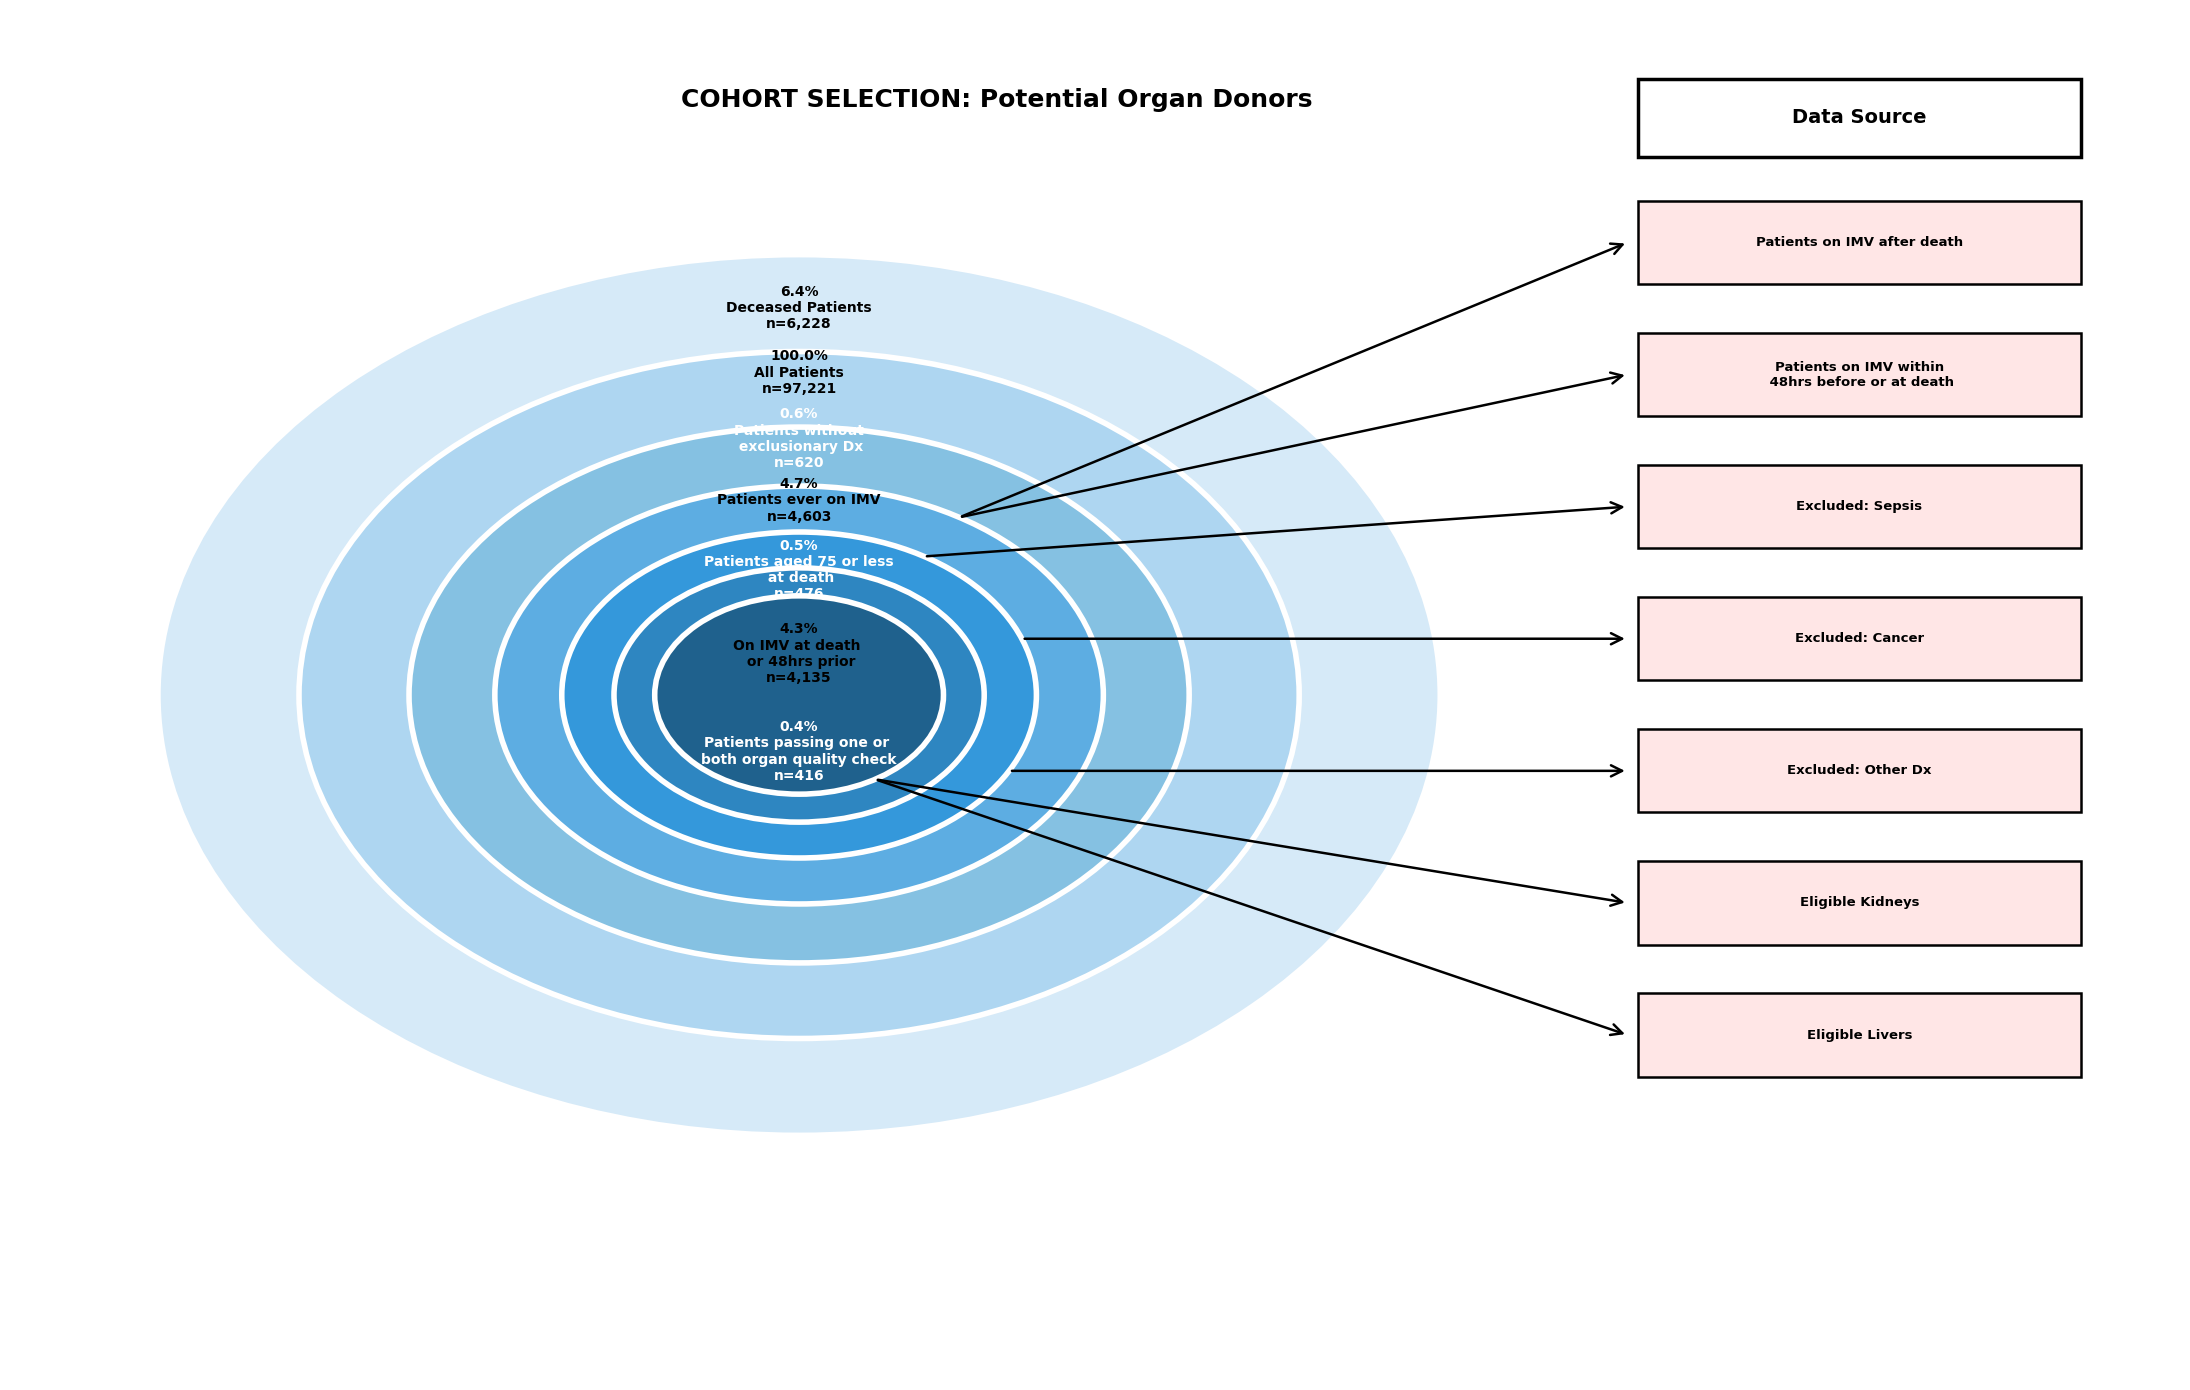

In [ ]:
# resp_expired_cohort_filtered_n

def get_drop_count(df, broad_label):
      row = df.filter(pl.col('dx_broad') == broad_label)
      if len(row) > 0:
          return int(row['n_patients_dropped'][0])
      return 0

steps = [
    {
        'label': 'All Patients',
        'n': total_patients,
    },
    {
        'label': 'Deceased Patients',
        'note': '(not including Hospice)',
        'n': expired_patients_n,
    },
    {
        'label': 'Patients ever on IMV',
        'n': imv_expired_patients,
    },
    {
        'label': 'On IMV at death \n or 48hrs prior',
        'n': imv_48hr_expire,
        'split': [
            {
                'label': 'Patients on IMV after death',
                'n': imv_after_expire,
            },
            {
                'label': 'Patients on IMV within\n 48hrs before or at death',
                'note': "Deceased Patients who were IMV on since 48hrs before death",
                'n': imv_48hr_expire - imv_after_expire,
            }
        ]
    },
    {
        'label': 'Patients without\n exclusionary Dx',
        'note': 'Dx excluding sepsis, cancers and positive cultures',
        'n': resp_expired_cohort_filtered_n,
        'split': [
            {
                'label': 'Excluded: Sepsis',
                'n': get_drop_count(drop_counts_by_broad, 'sepsis'),
            },
            {
                'label': 'Excluded: Cancer',
                'n': get_drop_count(drop_counts_by_broad, 'cancer'),
            },
            {
                'label': 'Excluded: Other Dx',
                'n': get_drop_count(drop_counts_by_broad, 'other'),
            }
        ]
    },
    {
        'label': 'Patients aged 75 or less\n at death',
        'n': age_relevant_cohort_n,
    },
    {
        'label': 'Patients passing one or \nboth organ quality check',
        'n': overall_organ_eligible_patients,
        'split': [
            {
                'label': 'Eligible Kidneys',
                'note': f" excluded on crrt {patients_crrt_n} patients followed by\n creatinine >4 {filtered_out_patients_count} patients",
                'n': eligible_kidney_n,
                'color': 'red'
            },
            {
                'label': 'Eligible Livers',
                'note': f"excluded \n bilirubin > 4 patients: {n_bili_gt4} | AST> 700 patients: {n_ast_gt700} | nALT>700 patients: {n_alt_gt700} ",
                'n': eligible_liver_n,
                'color': 'red'
            }
        ]
    },
]

fig = create_nested_funnel_diagram(
    steps,
    title="COHORT SELECTION: Potential Organ Donors"
)
fig.savefig("../output/final/cohort_strobe.png", bbox_inches="tight", dpi=300)
plt.show()